# PRIVACY POLICY ANALYSER BOT 

### step 1 :

In [18]:
# Cell 1: Install dependencies from requirements.txt
import os


# Install
!pip install -q -r requirements.txt

print("All dependencies installed successfully!")


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
All dependencies installed successfully!


In [19]:
!pip install -q gradio


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [20]:
# Cell 1: Install dependencies (Updated)
#!pip install langchain langchain-community langchain-openai langchain-text-splitters langgraph pydantic pypdf python-dotenv tiktoken faiss-cpu langsmith tavily-python gradio

In [21]:
# Cell 1: Install compatible LangChain version (v0.1.20)
#!pip install --force-reinstall langchain==0.1.20 langchain-community==0.0.38 langchain-core==0.1.52 langchain-openai==0.1.6 langgraph pydantic pypdf python-dotenv tiktoken faiss-cpu langsmith tavily-python gradio --force-reinstall

In [22]:
#pip install langchain.text_splitters

In [23]:
#pip install ipywidgets

In [24]:
# Cell 2: Import libraries and setup
import os
import json
import tempfile
from typing import List, Dict, Any, Optional
from dotenv import load_dotenv
from pypdf import PdfReader

# LangChain imports
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.documents import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import ChatPromptTemplate
from langchain.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

# LangGraph imports
from langgraph.graph import StateGraph, END

# LangSmith imports for tracing
from langsmith import Client
from langchain.callbacks.tracers import LangChainTracer

# Pydantic for structured output
from pydantic import BaseModel, Field

# ipywidgets for UI
import ipywidgets as widgets
from IPython.display import display, clear_output
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

# Load environment variables (ensure .env file has OPENAI_API_KEY and TAVILY_API_KEY)
load_dotenv()

# Set mock API keys if not present (replace with actual keys for production)
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY", "YOUR_OPENAI_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY", "YOUR_TAVILY_KEY")

print("Environment setup complete!")
print(" All necessary libraries imported.")

Environment setup complete!
 All necessary libraries imported.


In [25]:
# Cell 3: Setup LangSmith Tracing
def setup_tracing():
    """Setup LangSmith tracing for the entire project"""
    # Set up tracing environment
    os.environ["LANGCHAIN_TRACING_V2"] = "true"
    os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
    os.environ["LANGCHAIN_PROJECT"] = "Privacy-Policy-Analyzer-Capstone"
    
    if os.getenv("LANGCHAIN_API_KEY"):
        try:
            client = Client()
            tracer = LangChainTracer()
            print("LangSmith tracing enabled")
            print(f"Project: {os.environ['LANGCHAIN_PROJECT']}")
            return tracer, client
        except Exception as e:
            print(f"LangSmith setup failed: {e}")
            return None, None
    else:
        print("LangSmith API key not set. Tracing is disabled.")
        return None, None

tracer, langsmith_client = setup_tracing()

LangSmith tracing enabled
Project: Privacy-Policy-Analyzer-Capstone


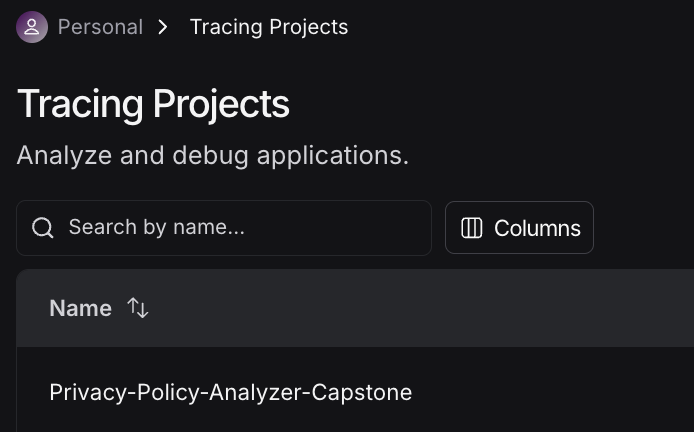

In [26]:
# Cell 4: Define data models (Hybrid: Simple Output + Loop State)
from typing import TypedDict, List, Dict, Any, Optional
from langchain_core.documents import Document
from pydantic import BaseModel, Field

class PrivacyPolicyAnalysis(BaseModel):
    """Structured analysis with direct, simple explanations."""
    # AI must identify the company first
    company_name: str = Field(..., description="The exact name of the app or company. If not found, output 'Unknown'.")
    
    
    # The "Real Talk" section - Simple English ONLY
    what_we_give: List[str] = Field(..., description="List of specific data types user gives (e.g., 'GPS Location', 'Contacts').")
    how_they_get_it: List[str] = Field(..., description="How they collect it (e.g., 'Cookies', 'Background Tracking').")
    why_they_want_it: List[str] = Field(..., description="The real reason they want it (e.g., 'Targeted Ads', 'Selling to Brokers').")
    
    # Standard compliance stuff
    retention_period: str = Field(default="Not specified", description="How long they keep data")
    risky_permissions: List[str] = Field(default_factory=list, description="Scary permissions (e.g., Microphone, Camera)")
    overall_risk_level: str = Field(..., description="Low, Medium, or High")
    
    # Explicit recommendations list
    recommendations: List[str] = Field(..., description="3-5 simple, actionable steps for the user.")

# Define the Graph State (Includes Loop fields)
class PolicyAnalyzerState(TypedDict):
    policy_text: str
    company_name: Optional[str] # Auto-filled
    chunks: List[Document]
    relevant_sections: Dict[str, str]
    extracted_info: Dict[str, Any]
    structured_analysis: Optional[PrivacyPolicyAnalysis]
    english_summary: str
    reputation_data: Dict[str, Any]
    error: Optional[str]
    # LOOP FIELDS (Required for the Feedback Logic)
    retry_count: int
    revision_feedback: Optional[str]

print("State updated: Simple Content Fields + Loop Logic enabled.")

State updated: Simple Content Fields + Loop Logic enabled.


In [27]:
# Cell 5: Document processing functions
class DocumentProcessor:
    def __init__(self):
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=1000,
            chunk_overlap=200,
            length_function=len,
        )
    
    def read_pdf(self, file_path: str) -> str:
        """Extract text from PDF file"""
        try:
            reader = PdfReader(file_path)
            text = "".join(page.extract_text() for page in reader.pages if page.extract_text())
            return text.strip()
        except Exception as e:
            return f"❌ Error reading PDF: {e}"
    
    def chunk_text(self, text: str) -> List[Document]:
        """Split text into manageable chunks for RAG"""
        if not text: return []
        try:
            documents = self.text_splitter.create_documents([text])
            return documents
        except Exception as e:
            return [Document(page_content=text)]

processor = DocumentProcessor()
print(" Document processor ready!")

 Document processor ready!


In [28]:
# Cell 6: Vector store and embeddings setup
class VectorStoreManager:
    def __init__(self):
        try:
            self.embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
            self.vector_store = None
            self.embeddings_available = True
        except Exception:
            self.embeddings_available = False
            self.vector_store = None
    
    def create_vector_store(self, documents: List[Document]):
        """Create FAISS vector store from documents (RAG foundation)"""
        if not documents: return None
        if not self.embeddings_available: return None
            
        try:
            self.vector_store = FAISS.from_documents(documents, self.embeddings)
            return self.vector_store
        except Exception as e:
            self.vector_store = None
            return None
    
    def search_relevant_sections(self, query: str, k: int = 3) -> List[Document]:
        """Search for relevant policy sections using semantic search"""
        if self.vector_store:
            try:
                return self.vector_store.similarity_search(query, k=k)
            except Exception as e:
                print(f"⚠️ Vector search failed: {e}. Using simple keyword fallback.")
                return []
        return []

vector_manager = VectorStoreManager()
print(" Vector store manager ready!")

 Vector store manager ready!


In [29]:
# Cell 7: LLM setup and prompt templates
try:
    # Main LLM for summaries
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    # Structured output LLM using Pydantic schema
    structured_llm = llm.with_structured_output(PrivacyPolicyAnalysis)
    # LLM capable of using tools (Tool-calling LLM)
    tool_llm = llm.bind_tools([TavilySearchResults(k=3)])
    
    print("LLMs initialized successfully (Standard, Structured, Tool-Calling).")
    
except Exception as e:
    print(f"❌ LLM initialization failed: {e}")

# Comprehensive prompt templates
EXTRACTION_PROMPT = ChatPromptTemplate.from_template("""
You are a privacy policy analyst. Analyze the following privacy policy text and extract structured information.
Focus ONLY on the provided PRIVACY POLICY TEXT.

PRIVACY POLICY TEXT:
{policy_text}

Return a comprehensive and accurate analysis using the provided JSON schema.
""")

SUMMARY_PROMPT = ChatPromptTemplate.from_template("""
Based on the following structured analysis and reputation check of a privacy policy, create a clear, plain-English summary for regular users.

STRUCTURED ANALYSIS:
{structured_analysis}

COMPANY REPUTATION (If available):
{reputation_data}

Please create a summary that:
1.  Summarizes what data is collected, shared, and retained.
2.  Clearly states the Overall Risk Level (Low/Medium/High) and justify it.
3.  Includes a section of 3-5 concise, practical suggestions for the user.
4.  If reputation data is available, integrate it into the risk assessment.
""")

print("LLM and prompts setup complete!")

LLMs initialized successfully (Standard, Structured, Tool-Calling).
LLM and prompts setup complete!


### prompt templates added 

In [30]:
# Cell 8: Define the Tavily Search Tool (Tool Calling LLM)
@tool
def tavily_search_tool(query: str) -> str:
    """
    Use this tool to search the internet for company reputation, privacy violation news,
    or general compliance history for the company name provided in the query.
    """
    search_tool = TavilySearchResults(k=3)
    return search_tool.invoke(query)

print(" Tavily Search Tool defined!")

 Tavily Search Tool defined!


In [31]:
# Cell 9: Define LangGraph nodes (Hybrid: Real Talk + Feedback Loop)
import json

def document_processing_node(state: PolicyAnalyzerState) -> PolicyAnalyzerState:
    """Node 1: Process document & Init Loop"""
    print("📄 Processing document...")
    state["retry_count"] = 0
    state["revision_feedback"] = None
    
    policy_text = state.get("policy_text", "") or "Privacy Policy."
    state["policy_text"] = policy_text
    state["chunks"] = processor.chunk_text(policy_text)
    return state

def rag_retrieval_node(state: PolicyAnalyzerState) -> PolicyAnalyzerState:
    """Node 2: RAG Retrieval"""
    print("🔍 RAG Retrieval...")
    if not state.get("chunks"): return state
    vector_manager.create_vector_store(state["chunks"])
    
    queries = [
        "who is this policy for company name", 
        "what personal data is collected GPS contacts photos",
        "how is data collected cookies tracking", 
        "why is data collected advertising selling"
    ]
    
    relevant_sections = {}
    for query in queries:
        docs = vector_manager.search_relevant_sections(query, k=2)
        relevant_sections[query] = "\n---\n".join([d.page_content for d in docs])
    
    state["relevant_sections"] = relevant_sections
    return state

def information_extraction_node(state: PolicyAnalyzerState) -> PolicyAnalyzerState:
    """Node 3: Extraction (Real Talk + Listens to Feedback)"""
    attempt = state.get("retry_count", 0) + 1
    print(f"📊 Extracting info (Attempt {attempt})...")
    
    combined_text = "\n\n".join(state.get("relevant_sections", {}).values())
    if not combined_text: combined_text = state.get("policy_text", "")[:3000]

    # THE SIMPLE, BRUTALLY HONEST PROMPT
    system_msg = """
    You are a brutally honest privacy researcher. 
    1. Identify the company name.
    2. Explain EXACTLY what is happening with user data in simple, direct English.
    
    RULES:
    - DO NOT use legal jargon.
    - Be cynical and direct.
    - If they share with "partners", say "Advertisers".
    """
    
    # INJECT FEEDBACK IF RETRYING
    feedback = state.get("revision_feedback")
    if feedback:
        print(f"   ⚠️ FEEDBACK RECEIVED: {feedback}")
        system_msg += f"\n\n🚨 IMPORTANT FIX NEEDED: Your previous attempt was incomplete. Feedback: {feedback}. Fix this now."

    try:
        analysis = structured_llm.invoke([
            ("system", system_msg),
            ("user", f"Analyze this policy text:\n\n{combined_text}")
        ])
        state["structured_analysis"] = analysis
        state["company_name"] = analysis.company_name # Auto-save name
        
    except Exception as e:
        state["error"] = f"Extraction failed: {e}"

    return state

# --- THE SIMPLE CRITIC NODE ---
def quality_assurance_node(state: PolicyAnalyzerState) -> PolicyAnalyzerState:
    """Node 3.5: Checks if the output is 'Empty' or 'Unknown'"""
    print("🧐 QA Critic: Checking for completeness...")
    
    analysis = state.get("structured_analysis")
    retry = state.get("retry_count", 0)
    feedback = []
    
    # Check 1: Unknown Company
    if not analysis or analysis.company_name.lower() in ["unknown", "not specified", "unknown app"]:
        feedback.append("You failed to find the Company Name.")

    # Check 2: Empty Lists (Lazy AI check)
    if not analysis or len(analysis.what_we_give) == 0:
        feedback.append("The 'What We Give' list is empty. Read the text again.")
        
    # LOGIC
    if feedback and retry < 2: # Allow 2 retries max
        state["revision_feedback"] = " & ".join(feedback)
        state["retry_count"] = retry + 1
        print("   ❌ QA FAILED. Sending back for fix.")
    else:
        state["revision_feedback"] = None
        print("   ✅ QA PASSED.")
        
    return state

def reputation_check_node(state: PolicyAnalyzerState) -> PolicyAnalyzerState:
    """Node 4: Reputation (Auto-Detect + Force Search)"""
    print("🌐 Checking reputation...")
    company_name = state.get("company_name")
    
    if not company_name or company_name == "Unknown":
        state["reputation_data"] = {"summary": "Could not identify company name."}
        return state

    try:
        # Force the search
        print(f"   Running search for: {company_name}")
        search_tool = TavilySearchResults(k=3)
        search_results = search_tool.invoke(f"{company_name} privacy data breach scandal")
        
        # Simple summary
        summary_prompt = ChatPromptTemplate.from_template("""
        Summarize these search results for {company} into 3 simple bullet points.
        Focus on: Data breaches, Fines, or "Clean Record".
        Keep it short and simple.
        
        Results: {results}
        """)
        
        chain = summary_prompt | llm
        summary_response = chain.invoke({"company": company_name, "results": str(search_results)})
        
        state["reputation_data"] = {
            "company": company_name,
            "summary": summary_response.content
        }
    except Exception:
        state["reputation_data"] = {"summary": "Reputation check failed (Network Error)."}
        
    return state

def summary_generation_node(state: PolicyAnalyzerState) -> PolicyAnalyzerState:
    return state # Pass-through

print(" Nodes updated")

 Nodes updated


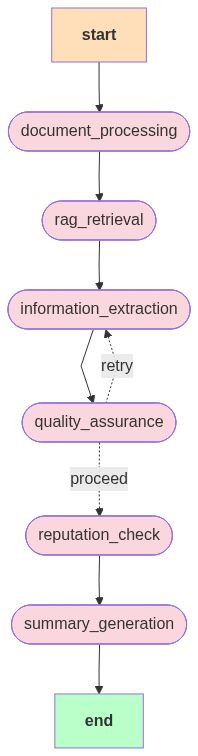

Graph Compiled: Simple Output Content + Advanced Self-Correction Loop.


In [32]:
# Cell 10: Compile the LangGraph

# The Router Function
def route_qa(state: PolicyAnalyzerState):
    """If there is feedback, RETRY. If not, PROCEED."""
    if state.get("revision_feedback"):
        return "retry"
    return "proceed"

workflow = StateGraph(PolicyAnalyzerState)

# Add Nodes
workflow.add_node("document_processing", document_processing_node)
workflow.add_node("rag_retrieval", rag_retrieval_node)
workflow.add_node("information_extraction", information_extraction_node)
workflow.add_node("quality_assurance", quality_assurance_node) # The Critic
workflow.add_node("reputation_check", reputation_check_node)
workflow.add_node("summary_generation", summary_generation_node)

# Add Edges
workflow.set_entry_point("document_processing")
workflow.add_edge("document_processing", "rag_retrieval")
workflow.add_edge("rag_retrieval", "information_extraction")
workflow.add_edge("information_extraction", "quality_assurance")

# THE CONDITIONAL LOOP
workflow.add_conditional_edges(
    "quality_assurance",
    route_qa,
    {
        "retry": "information_extraction", # Go back!
        "proceed": "reputation_check"      # Go forward!
    }
)

workflow.add_edge("reputation_check", "summary_generation")
workflow.add_edge("summary_generation", END)

# Compile
# Use MemorySaver() so state is lost when you restart the kernel
memory = MemorySaver()

# Pass the checkpointer here
#app = workflow.compile(checkpointer=memory)
analyzer_workflow = workflow.compile(checkpointer=memory)
display(Image(analyzer_workflow.get_graph().draw_mermaid_png()))
print("Graph Compiled: Simple Output Content + Advanced Self-Correction Loop.")

In [33]:
# Cell 11: Main Privacy Policy Analyzer class
class PrivacyPolicyAnalyzer:
    def __init__(self):
        self.workflow = analyzer_workflow
        self.processor = DocumentProcessor()
        self.tracer = tracer
        print("Initializing Privacy Policy Analyzer...")
        print("Analyzer initialized with enhanced workflow.")

    def analyze_policy(self, file_content_or_path: Optional[str] = None, policy_text: Optional[str] = None, company_name: Optional[str] = None) -> dict:
        """Run the full analysis workflow."""



        # 1. Get Text Content
        if policy_text:
            text_to_analyze = policy_text
        elif file_content_or_path:
            if file_content_or_path.lower().endswith('.pdf'):
                text_to_analyze = self.processor.read_pdf(file_content_or_path)
            else:
                try:
                    with open(file_content_or_path, 'r', encoding='utf-8') as f:
                        text_to_analyze = f.read()
                except:
                    text_to_analyze = file_content_or_path
        else:
            text_to_analyze = ""

        if not text_to_analyze or text_to_analyze.startswith("❌ Error"):
            return {"error": text_to_analyze if text_to_analyze else "No policy text provided."}

        # 2. Config & Tracing
        config = {"configurable": {"thread_id": "policy-analysis-5"}}
        if self.tracer:
            config["callbacks"] = [self.tracer]

        # 3. FIX: Initialize COMPLETE State to prevent KeyErrors
        initial_state: PolicyAnalyzerState = {
            "policy_text": text_to_analyze,
            "company_name": company_name,
            "chunks": [],              # Explicitly init list
            "relevant_sections": {},   # Explicitly init dict
            "extracted_info": {},
            "structured_analysis": None,
            "english_summary": "",
            "reputation_data": {},
            "error": None
        }

        try:
            # 4. Invoke Workflow
            final_state = self.workflow.invoke(initial_state, config=config)

            # 5. Process Results
            structured = final_state.get('structured_analysis')
            reputation = final_state.get('reputation_data')
            summary_content = final_state.get('english_summary', 'Summary generation failed.')

            suggestions = []
            if "RECOMMENDATIONS:" in summary_content:
                # Basic parsing for suggestions list
                parts = summary_content.split('RECOMMENDATIONS:')[-1].split('\n')
                suggestions = [line.strip().replace('-', '').strip() for line in parts if line.strip().startswith('-')][:4]

            result = {
                "structured_analysis": structured.model_dump() if structured else {},
                "reputation_check": reputation if reputation else {"status": "Skipped"},
                "user_friendly_output": {
                    "english_summary": summary_content,
                    "suggestions": suggestions,
                    "overall_risk": structured.overall_risk_level if structured else "Unknown",
                    "company_name": company_name if company_name else "N/A"
                },
                "metadata": {
                    "tracing_enabled": self.tracer is not None,
                }
            }
            return result

        except Exception as e:
            import traceback
            traceback.print_exc() # Print full error to console for debugging
            return {"error": f"An error occurred during workflow execution: {str(e)}"}

enhanced_analyzer = PrivacyPolicyAnalyzer()
print("\nPrivacy Policy Analyzer class ready!")

Initializing Privacy Policy Analyzer...
Analyzer initialized with enhanced workflow.

Privacy Policy Analyzer class ready!


In [34]:
# Cell 11: Final Gradio UI
import gradio as gr
import json

def format_magic_report(results):
    """Generates a beautiful, seamless HTML report with enforced high contrast."""
    if "error" in results:
        return f"⚠️ Error: {results['error']}"

    struct = results.get("structured_analysis", {})
    if not struct: return "⚠️ No analysis generated. Please ensure the policy text is valid."

    # Data Extraction
    company = struct.get('company_name', 'Unknown App')
    what = struct.get('what_we_give', [])
    how = struct.get('how_they_get_it', [])
    why = struct.get('why_they_want_it', [])
    recs = struct.get('recommendations', [])
    risk = struct.get('overall_risk_level', 'Unknown')

    # Reputation Data
    rep_data = results.get("reputation_check", {})
    rep_summary = rep_data.get("summary", "No reputation data available.")

    # Visual Logic
    header_color = "#22c55e" # Green default
    risk_icon = "✅"
    risk_bg = "rgba(34, 197, 94, 0.1)"

    if "High" in risk:
        header_color = "#ef4444" # Red
        risk_icon = "🚨"
        risk_bg = "rgba(239, 68, 68, 0.1)"
    elif "Medium" in risk:
        header_color = "#f97316" # Orange
        risk_icon = "⚠️"
        risk_bg = "rgba(249, 115, 22, 0.1)"

    # --- THE REPORT TEMPLATE ---
    # Global container forces white background and dark text
    html_content = f"""
    <div style="font-family: sans-serif; max-width: 800px; margin: 0 auto; border: 1px solid #e5e7eb; padding: 25px; border-radius: 12px; background-color: #ffffff; color: #1f2937;">

        <div style="background-color: {risk_bg}; border-left: 6px solid {header_color}; padding: 20px; border-radius: 6px; margin-bottom: 30px;">
            <h1 style="color: {header_color}; margin:0; font-size: 26px; font-weight: 700;">{risk_icon} {company} is {risk.upper()} RISK</h1>
            <p style="margin-top:8px; opacity: 0.9; color: #374151; font-weight: 500;">Privacy Policy Analysis Report</p>
        </div>

        <h3 style="border-bottom: 2px solid #e5e7eb; padding-bottom: 10px; color: #111827; margin-top: 0;">🌍 Public Reputation Check</h3>
        <div style="background-color: #f3f4f6; padding: 15px; border-radius: 8px; margin-bottom: 30px; color: #1f2937; border: 1px solid #e5e7eb;">
            {rep_summary}
        </div>

        <h3 style="border-bottom: 2px solid #e5e7eb; padding-bottom: 10px; color: #111827;">🧐 The Privacy Breakdown</h3>
        <p style="color: #4b5563; margin-bottom: 15px;">Here is exactly what they are doing with your data:</p>

        <table style="width:100%; border-collapse: separate; border-spacing: 0; border: 1px solid #e5e7eb; border-radius: 8px; overflow: hidden; margin-bottom: 30px;">
            <thead>
                <tr style="background-color: #f9fafb; text-align: left;">
                    <th style="padding: 12px 15px; border-bottom: 1px solid #e5e7eb; color: #111827; font-weight: 600; width: 33%;">📤 WHAT YOU GIVE</th>
                    <th style="padding: 12px 15px; border-bottom: 1px solid #e5e7eb; color: #111827; font-weight: 600; width: 33%; border-left: 1px solid #e5e7eb;">🕵️ HOW THEY TAKE IT</th>
                    <th style="padding: 12px 15px; border-bottom: 1px solid #e5e7eb; color: #111827; font-weight: 600; width: 33%; border-left: 1px solid #e5e7eb;">💸 WHY THEY WANT IT</th>
                </tr>
            </thead>
            <tbody>
                <tr>
                    <td style="padding: 15px; vertical-align: top; color: #374151; line-height: 1.5;">{ '<br><br>'.join([f"• {x}" for x in what]) }</td>
                    <td style="padding: 15px; vertical-align: top; color: #374151; border-left: 1px solid #e5e7eb; line-height: 1.5;">{ '<br><br>'.join([f"• {x}" for x in how]) }</td>
                    <td style="padding: 15px; vertical-align: top; color: #374151; border-left: 1px solid #e5e7eb; line-height: 1.5;">{ '<br><br>'.join([f"• {x}" for x in why]) }</td>
                </tr>
            </tbody>
        </table>

        <h3 style="border-bottom: 2px solid #e5e7eb; padding-bottom: 10px; color: #111827;">🛡️ How to Protect Yourself</h3>
        <ul style="font-size: 16px; line-height: 1.7; color: #333333; padding-left: 20px; font-weight: 500;">
    """

    for r in recs:
        # Extra safety: Inline style on the LI tag itself
        html_content += f"<li style='margin-bottom: 8px; color: #333333;'>{r}</li>"

    html_content += "</ul></div>"

    return html_content

def run_gradio_analysis(file_obj, text_input):
    # 1. Inputs
    file_path = None
    if file_obj is not None:
        if isinstance(file_obj, str):
            file_path = file_obj
        elif hasattr(file_obj, 'name'):
            file_path = file_obj.name

    # 2. Run
    try:
        results = enhanced_analyzer.analyze_policy(
            file_content_or_path=file_path,
            policy_text=text_input,
            company_name=None
        )
    except Exception as e:
        return f"❌ Critical Error: {str(e)}", {}

    # 3. Format
    report = format_magic_report(results)
    return report, results

# --- UI Layout ---
with gr.Blocks() as app:

    gr.Markdown(
        """
        # 🕵️‍♂️ Privacy Policy Decoder
        **Upload a PDF, and I'll tell you who they are, what they take, and if you should trust them.**
        """
    )

    with gr.Row():
        with gr.Column(scale=1):
            f_in = gr.File(label="📄 Upload Policy (PDF/TXT)")
            t_in = gr.Textbox(label="📝 Or Paste Text", lines=5, placeholder="Paste the legal text here...")
            btn = gr.Button("✨ Decode Privacy Policy", variant="primary")

        with gr.Column(scale=2):
            out_view = gr.HTML(label="Privacy Report")
            out_json = gr.JSON(label="Raw Data", visible=False)

    btn.click(fn=run_gradio_analysis, inputs=[f_in, t_in], outputs=[out_view, out_json])

print("UI Launched! Click the link below.")
app.launch(share=True)

UI Launched! Click the link below.
* Running on local URL:  http://127.0.0.1:7872
* Running on public URL: https://81fc2c5614bec1d2d5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## PHOTOS OF THE WEBSITE WHERE MY BOT CAN BE ACCESSED

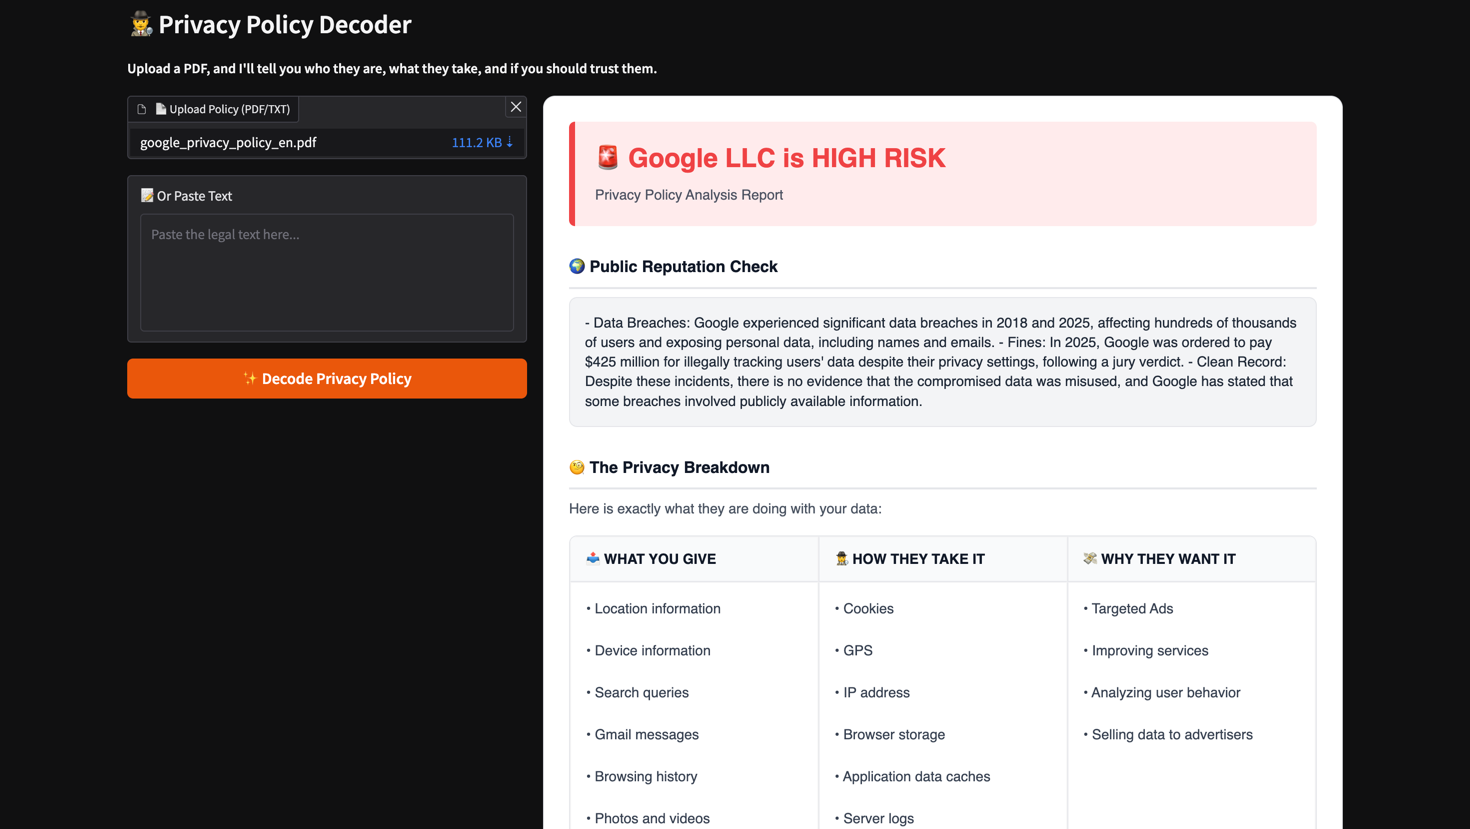

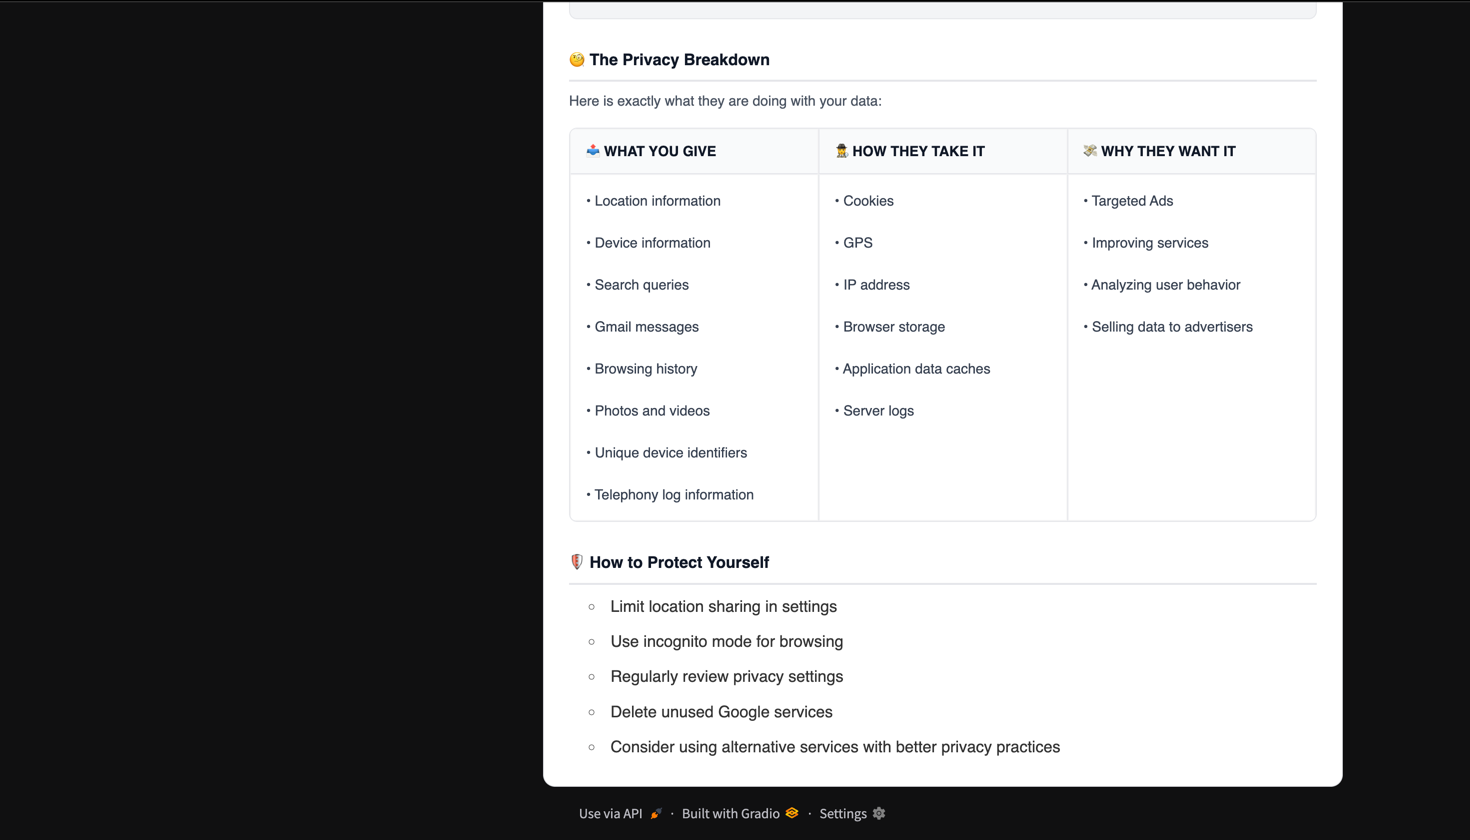

### Example where I gave the privacy policy as a copy paste txt input :
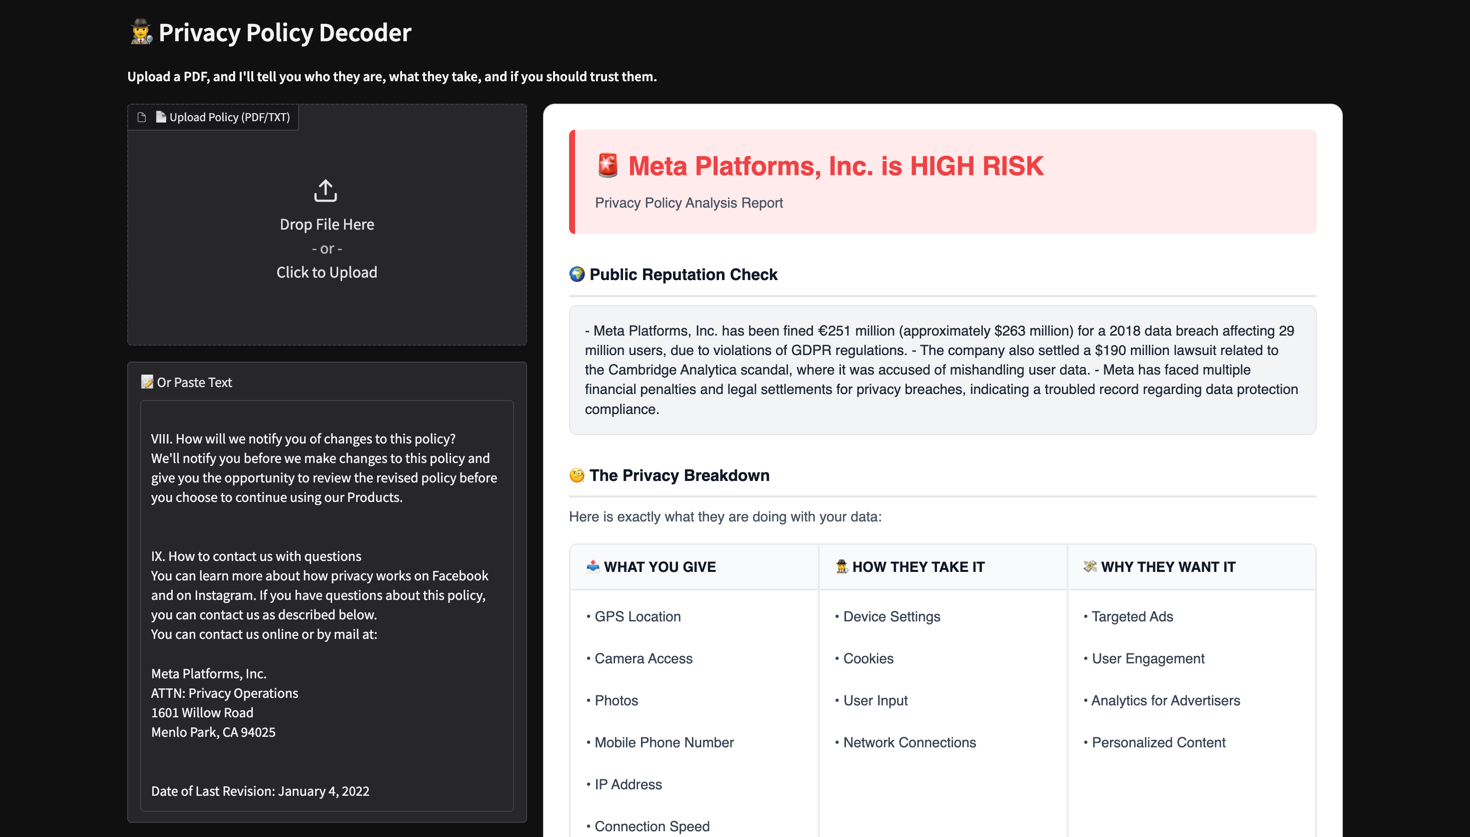
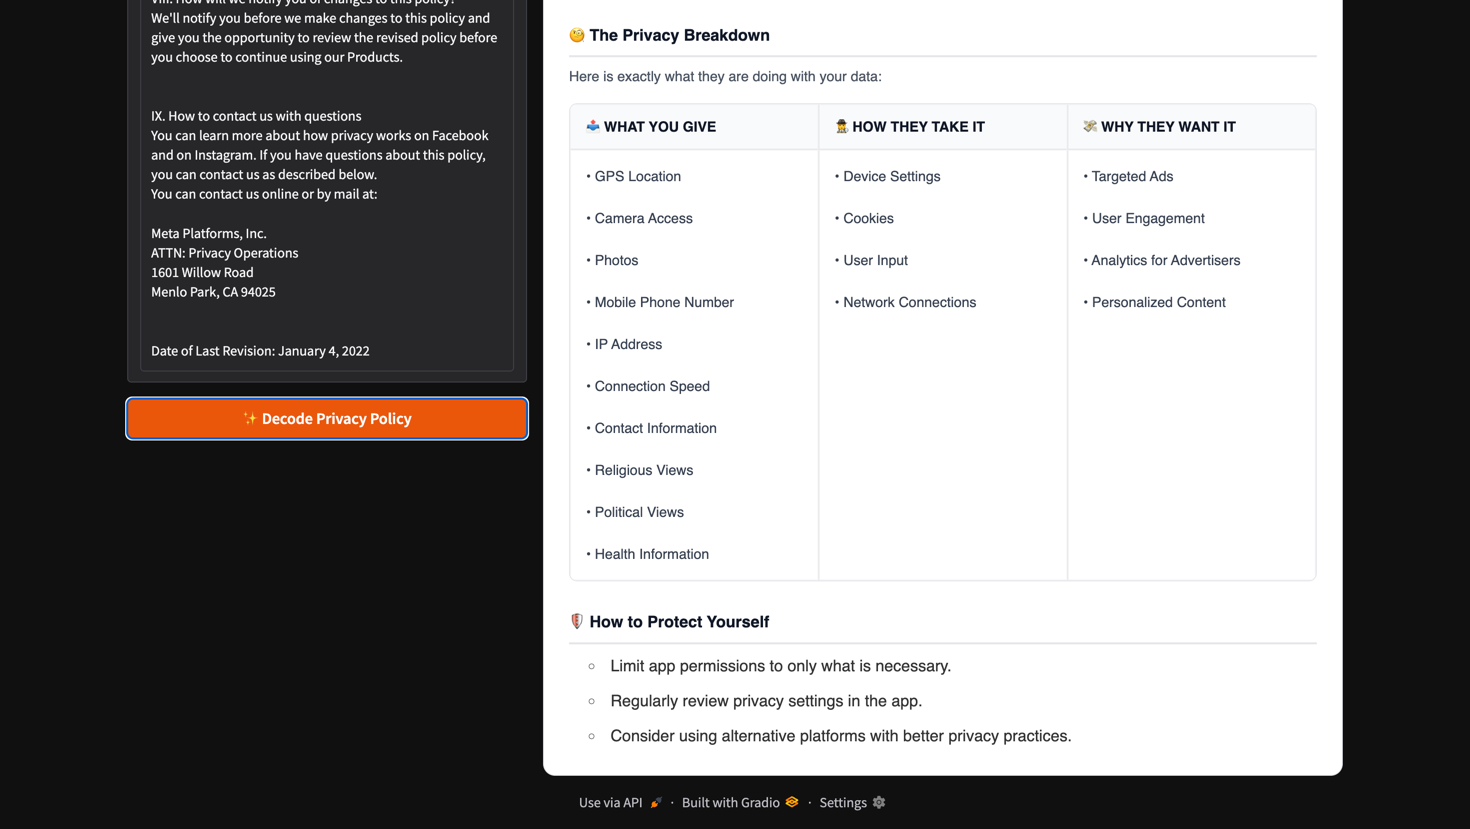